# Aerial Image Segmentation: Computer Vision with PyTorch

---

Dataset: [Massachusetts Roads Dataset](https://www.cs.toronto.edu/~vmnih/data/)

Created for Coursera Guided Project: [Aerial Image Segmentation with PyTorch](https://www.coursera.org/learn/aerial-image-segmentation-with-pytorch/home/week/1))

_IMPORTANT: This notebook differs from original one provided during the guided project at Coursera. I made some adjustments to improve code quality using some skills I've learned and I believe they make the code more optimized, organized and readable._

---

## Task 1 : Introduction

## Task 2: Setup and Imports

1. Installing Segmentations Models PyTorch package
2. Download Massachussets Roads subset dataset
3. Import libraries

### Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 44.38 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  / 255

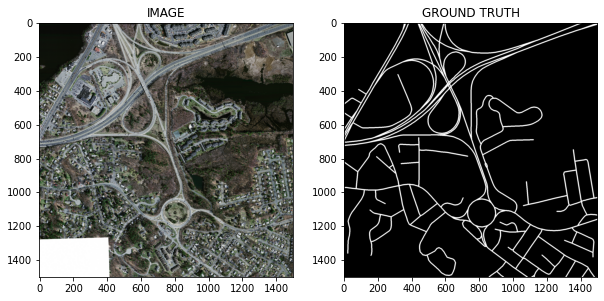

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap='gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [13]:
import albumentations as A

In [14]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Task 4 : Create Custom Dataset 

In [15]:
from torch.utils.data import Dataset

In [22]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.iloc[idx]

        image_path = DATA_DIR + row.images
        mask_path = DATA_DIR + row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
    
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [23]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [18]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


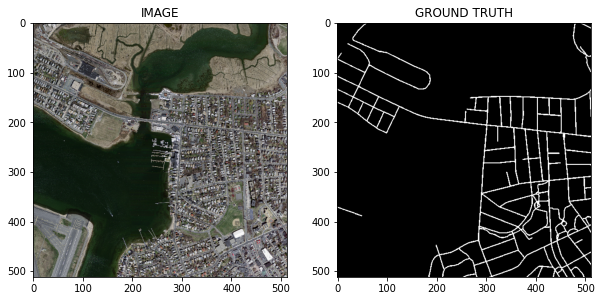

In [24]:
idx = 3

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [25]:
from torch.utils.data import DataLoader

In [26]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [27]:
print(f'Total no. of batcher in trainloader: {len(trainloader)}')
print(f'Total no. of batcher in validloader: {len(validloader)}')

Total no. of batcher in trainloader: 20
Total no. of batcher in validloader: 5


In [28]:
for images, masks in trainloader:
    print(f'One batch image shape: {images.shape}')
    print(f'One batch mask shape: {masks.shape}')
    break

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [29]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [37]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)

        if masks is not None:
            return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

        return logits        

In [40]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function 

In [41]:
def train_fn(dataloader, model, optimizer):
    model.train()

    total_loss = 0.0

    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [42]:
def eval_fn(dataloader, model):
    model.eval()

    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [44]:
best_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_loss:
        torch.save(model.state_dict(), 'best-model.pt')
        print('SAVED MODEL')
        best_loss = valid_loss

    print(f'Epoch: {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}')

100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED MODEL
Epoch: 1 Train Loss: 0.9706616848707199 Valid Loss: 0.9903236746788024


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED MODEL
Epoch: 2 Train Loss: 0.7510104447603225 Valid Loss: 0.8241815686225891


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED MODEL
Epoch: 3 Train Loss: 0.6991430878639221 Valid Loss: 0.7041840434074402


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 4 Train Loss: 0.6835705697536468 Valid Loss: 0.7585808515548706


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED MODEL
Epoch: 5 Train Loss: 0.6611935049295425 Valid Loss: 0.5999566793441773


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch: 6 Train Loss: 0.6468157857656479 Valid Loss: 0.6678513169288636


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 7 Train Loss: 0.6360000520944595 Valid Loss: 0.6247897624969483


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch: 8 Train Loss: 0.6354943543672562 Valid Loss: 0.6385769367218017


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 9 Train Loss: 0.6350242763757705 Valid Loss: 0.6644760847091675


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED MODEL
Epoch: 10 Train Loss: 0.6256454318761826 Valid Loss: 0.589775949716568


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 11 Train Loss: 0.613276618719101 Valid Loss: 0.616358482837677


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED MODEL
Epoch: 12 Train Loss: 0.6034642294049263 Valid Loss: 0.5732188940048217


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 13 Train Loss: 0.5976550251245498 Valid Loss: 0.5949044823646545


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 14 Train Loss: 0.6008681565523147 Valid Loss: 0.5820251286029816


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch: 15 Train Loss: 0.600653500854969 Valid Loss: 0.6397335171699524


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 16 Train Loss: 0.6104851439595222 Valid Loss: 0.7192146897315979


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 17 Train Loss: 0.605870246887207 Valid Loss: 0.5735860228538513


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch: 18 Train Loss: 0.5841364994645118 Valid Loss: 0.6010918974876404


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED MODEL
Epoch: 19 Train Loss: 0.5817144185304641 Valid Loss: 0.5686661899089813


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED MODEL
Epoch: 20 Train Loss: 0.5828023105859756 Valid Loss: 0.5682514131069183


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED MODEL
Epoch: 21 Train Loss: 0.5859751731157303 Valid Loss: 0.5515274167060852


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch: 22 Train Loss: 0.5793715223670006 Valid Loss: 0.6370105981826782


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 23 Train Loss: 0.5773965656757355 Valid Loss: 0.5546380877494812


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED MODEL
Epoch: 24 Train Loss: 0.5698597684502602 Valid Loss: 0.5478797972202301


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

SAVED MODEL
Epoch: 25 Train Loss: 0.566319826245308 Valid Loss: 0.5380135953426362


# Task 9 : Inference

In [45]:
idx = 17
image, mask = validset[idx]

model.load_state_dict(torch.load('/content/best-model.pt'))

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

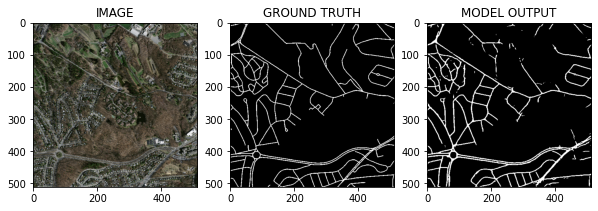

In [46]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))